In [ ]:
# rootni avtomatik topadi va os.chdir(PROJECT_ROOT) qiladi

# best model (OvR LogReg) uchun 1 ta label tanlab (yoki siz berasiz) SHAP global + local qiladi

# visuals/SHAP/ ga PNG/HTML saqlaydi

# har plotni save + show qiladi (run qilgandan keyin pastida ko‘rinadi)

# global’da “+=” (sign) bilan featurelar hissa qo‘shgan/qo‘shmaganini ko‘rsatadigan signed bar ham bor.



In [1]:
#CELL 1 — Root fix + output folder
from __future__ import annotations
import os
from pathlib import Path

def find_project_root(start: Path | None = None) -> Path:
    start = start or Path.cwd()
    for p in [start] + list(start.parents):
        if (p / "Data").exists() and (p / "Models").exists():
            return p
    for p in [start] + list(start.parents):
        if (p / "Data").exists():
            return p
    return start

PROJECT_ROOT = find_project_root()
os.chdir(PROJECT_ROOT)

VIS_DIR = PROJECT_ROOT / "visuals" / "SHAP"
VIS_DIR.mkdir(parents=True, exist_ok=True)

print("✅ PROJECT_ROOT:", PROJECT_ROOT.resolve())
print("✅ VIS_DIR     :", VIS_DIR.resolve())

✅ PROJECT_ROOT: C:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract
✅ VIS_DIR     : C:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\visuals\SHAP


In [2]:
#CELL 2 — Config (sizning real pathlaringiz)
FE_VERSION = "fe_v1"
FS_VERSION = "fe_v1_fs_chi2_v1"
MODEL_NAME = "optuna_logreg_best"

# qaysi labelni explain qilamiz?
# None bo‘lsa -> Y_test support eng kattasini tanlaydi
LABEL_TO_EXPLAIN = None  # masalan: "cardiovascular"

# SHAP sample sizes (katta bo‘lsa sekinlashadi)
N_BG = 200          # background
N_EXPLAIN = 400     # explain

TOP_N = 30          # global plotlarda ko‘rsatiladigan top-N feature
RANDOM_STATE = 42

In [3]:
#CELL 3 — Imports + meta_to_sparse FIX (joblib featurizer load uchun)
import json, re
import numpy as np
import pandas as pd
from scipy import sparse
import joblib
import matplotlib.pyplot as plt

import shap  # pip install shap

from sklearn.preprocessing import FunctionTransformer
import __main__

plt.rcParams["figure.dpi"] = 120
rng = np.random.default_rng(RANDOM_STATE)

# ---- meta_to_sparse (sizning 09_feature_engineering CELL 4) ----
_term_split = re.compile(r"\s*;\s*")

def meta_features(texts: list[str]) -> np.ndarray:
    lens, n_terms, n_uniq_terms = [], [], []
    for s in texts:
        s = (s or "").strip()
        lens.append(len(s))
        if not s:
            n_terms.append(0); n_uniq_terms.append(0); continue
        terms = [t.strip().lower() for t in _term_split.split(s) if t.strip()]
        n_terms.append(len(terms))
        n_uniq_terms.append(len(set(terms)))

    lens = np.array(lens, dtype=np.float32).reshape(-1, 1)
    n_terms = np.array(n_terms, dtype=np.float32).reshape(-1, 1)
    n_uniq_terms = np.array(n_uniq_terms, dtype=np.float32).reshape(-1, 1)
    feats = np.hstack([np.log1p(lens), n_terms, n_uniq_terms]).astype(np.float32)
    return feats

def meta_to_sparse(texts):
    feats = meta_features(list(texts))
    return sparse.csr_matrix(feats)

# joblib pickle __main__.meta_to_sparse qidirgani uchun inject
setattr(__main__, "_term_split", _term_split)
setattr(__main__, "meta_features", meta_features)
setattr(__main__, "meta_to_sparse", meta_to_sparse)
setattr(__main__, "FunctionTransformer", FunctionTransformer)
setattr(__main__, "sparse", sparse)

meta_transformer = FunctionTransformer(meta_to_sparse, validate=False)

c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\env_folder\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#CELL 4 — Load: featurizer + selector(mask) + model + thresholds + labels + X_test/Y_test
# paths
VECT_PATH = PROJECT_ROOT / "Data" / "Engineered_data" / FE_VERSION / "tfidf_vectorizer.joblib"
SEL_PATH  = PROJECT_ROOT / "Data" / "Feature_Selected" / FS_VERSION / "feature_selector.joblib"

MODEL_DIR  = PROJECT_ROOT / "Models" / "best_model" / MODEL_NAME
MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}.joblib"
THR_PATH   = MODEL_DIR / f"{MODEL_NAME}_thresholds.json"

META_CANDIDATES = [
    PROJECT_ROOT / "Data" / "Feature_Selected" / FS_VERSION / "engineered_meta.json",
    PROJECT_ROOT / "Data" / "Engineered_data" / FE_VERSION / "meta.json",
]

X_TEST_PATH  = PROJECT_ROOT / "Data" / "Feature_Selected" / FS_VERSION / "X_test.npz"
Y_TEST_PATH  = PROJECT_ROOT / "Data" / "Feature_Selected" / FS_VERSION / "Y_test.npy"
X_TRAIN_PATH = PROJECT_ROOT / "Data" / "Feature_Selected" / FS_VERSION / "X_train.npz"

assert VECT_PATH.exists(), f"Topilmadi: {VECT_PATH}"
assert SEL_PATH.exists(),  f"Topilmadi: {SEL_PATH}"
assert MODEL_PATH.exists(), f"Topilmadi: {MODEL_PATH}"
assert THR_PATH.exists(),   f"Topilmadi: {THR_PATH}"
assert X_TEST_PATH.exists(), f"Topilmadi: {X_TEST_PATH}"

featurizer = joblib.load(VECT_PATH)

selector_payload = joblib.load(SEL_PATH)
assert isinstance(selector_payload, dict) and "mask" in selector_payload, "feature_selector.joblib ichida 'mask' bo‘lishi kerak"
mask = np.array(selector_payload["mask"], dtype=bool)

model = joblib.load(MODEL_PATH)

with open(THR_PATH, "r", encoding="utf-8") as f:
    thr_dict = json.load(f)

meta_path = next((p for p in META_CANDIDATES if p.exists()), None)
assert meta_path is not None, f"Meta topilmadi: {META_CANDIDATES}"
with open(meta_path, "r", encoding="utf-8") as f:
    meta = json.load(f)

y_cols = meta["y_cols"]
label_names = [c.replace("y_", "", 1) for c in y_cols]
thr = np.array([float(thr_dict.get(name, 0.5)) for name in label_names], dtype=float)

X_test = sparse.load_npz(X_TEST_PATH).tocsr()
Y_test = np.load(Y_TEST_PATH) if Y_TEST_PATH.exists() else None
X_train = sparse.load_npz(X_TRAIN_PATH).tocsr() if X_TRAIN_PATH.exists() else None

print("✅ X_test:", X_test.shape)
print("✅ Y_test:", None if Y_test is None else Y_test.shape)
print("✅ labels:", len(label_names))

✅ X_test: (24164, 33671)
✅ Y_test: (24164, 21)
✅ labels: 21


In [5]:
# CELL 5 — Feature names (selected) + choose label + pick OvR estimator
def _get_names_vectorizer(v):
    # sklearn version farqini ko‘tarish
    if hasattr(v, "get_feature_names_out"):
        return list(v.get_feature_names_out())
    if hasattr(v, "get_feature_names"):
        return list(v.get_feature_names())
    return []

def get_feature_names_from_union(union_obj) -> list[str]:
    names = []
    for prefix, tr in union_obj.transformer_list:
        fn = _get_names_vectorizer(tr)
        if fn:
            names.extend([f"{prefix}__{x}" for x in fn])
        else:
            if prefix == "meta":
                names.extend(["meta__log1p_len", "meta__n_terms", "meta__n_uniq_terms"])
            else:
                names.append(f"{prefix}__feature")
    return names

feature_names_full = get_feature_names_from_union(featurizer)
d0 = featurizer.transform(pd.Series(["test"])).shape[1]
assert len(feature_names_full) == d0, f"feature_names_full mismatch: {len(feature_names_full)} vs {d0}"

feature_names_selected = np.array(feature_names_full)[mask]
assert len(feature_names_selected) == X_test.shape[1], "mask dim X_test dim bilan mos emas"

# label choose
if LABEL_TO_EXPLAIN is None:
    if Y_test is not None:
        supports = Y_test.sum(axis=0)
        label_idx = int(np.argmax(supports))
        LABEL_TO_EXPLAIN = label_names[label_idx]
    else:
        label_idx = 0
        LABEL_TO_EXPLAIN = label_names[0]
else:
    label_idx = label_names.index(LABEL_TO_EXPLAIN)

# pick estimator for that label (OvR)
estimator = model.estimators_[label_idx] if hasattr(model, "estimators_") else model

print("✅ LABEL_TO_EXPLAIN:", LABEL_TO_EXPLAIN, "| idx:", label_idx)
print("✅ Estimator type:", type(estimator))

✅ LABEL_TO_EXPLAIN: dermatologic | idx: 1
✅ Estimator type: <class 'sklearn.linear_model._logistic.LogisticRegression'>


In [6]:
# CELL 6 — SHAP compute (LinearExplainer orqali) + helper save+show
def save_and_show(fig_path: Path, title: str | None = None):
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

# sample explain + background
n = X_test.shape[0]
idx_explain = rng.choice(n, size=min(N_EXPLAIN, n), replace=False)
X_explain = X_test[idx_explain]

if X_train is not None:
    ntr = X_train.shape[0]
    idx_bg = rng.choice(ntr, size=min(N_BG, ntr), replace=False)
    X_bg = X_train[idx_bg]
else:
    idx_bg = rng.choice(n, size=min(N_BG, n), replace=False)
    X_bg = X_test[idx_bg]

print("X_explain:", X_explain.shape, "| X_bg:", X_bg.shape)

# SHAP explainer
masker = shap.maskers.Independent(X_bg)
explainer = shap.Explainer(estimator, masker, feature_names=list(feature_names_selected))

shap_exp = explainer(X_explain)
vals = shap_exp.values  # (n_samples, n_features)
print("✅ SHAP values shape:", vals.shape)

X_explain: (400, 33671) | X_bg: (200, 33671)
✅ SHAP values shape: (400, 33671)


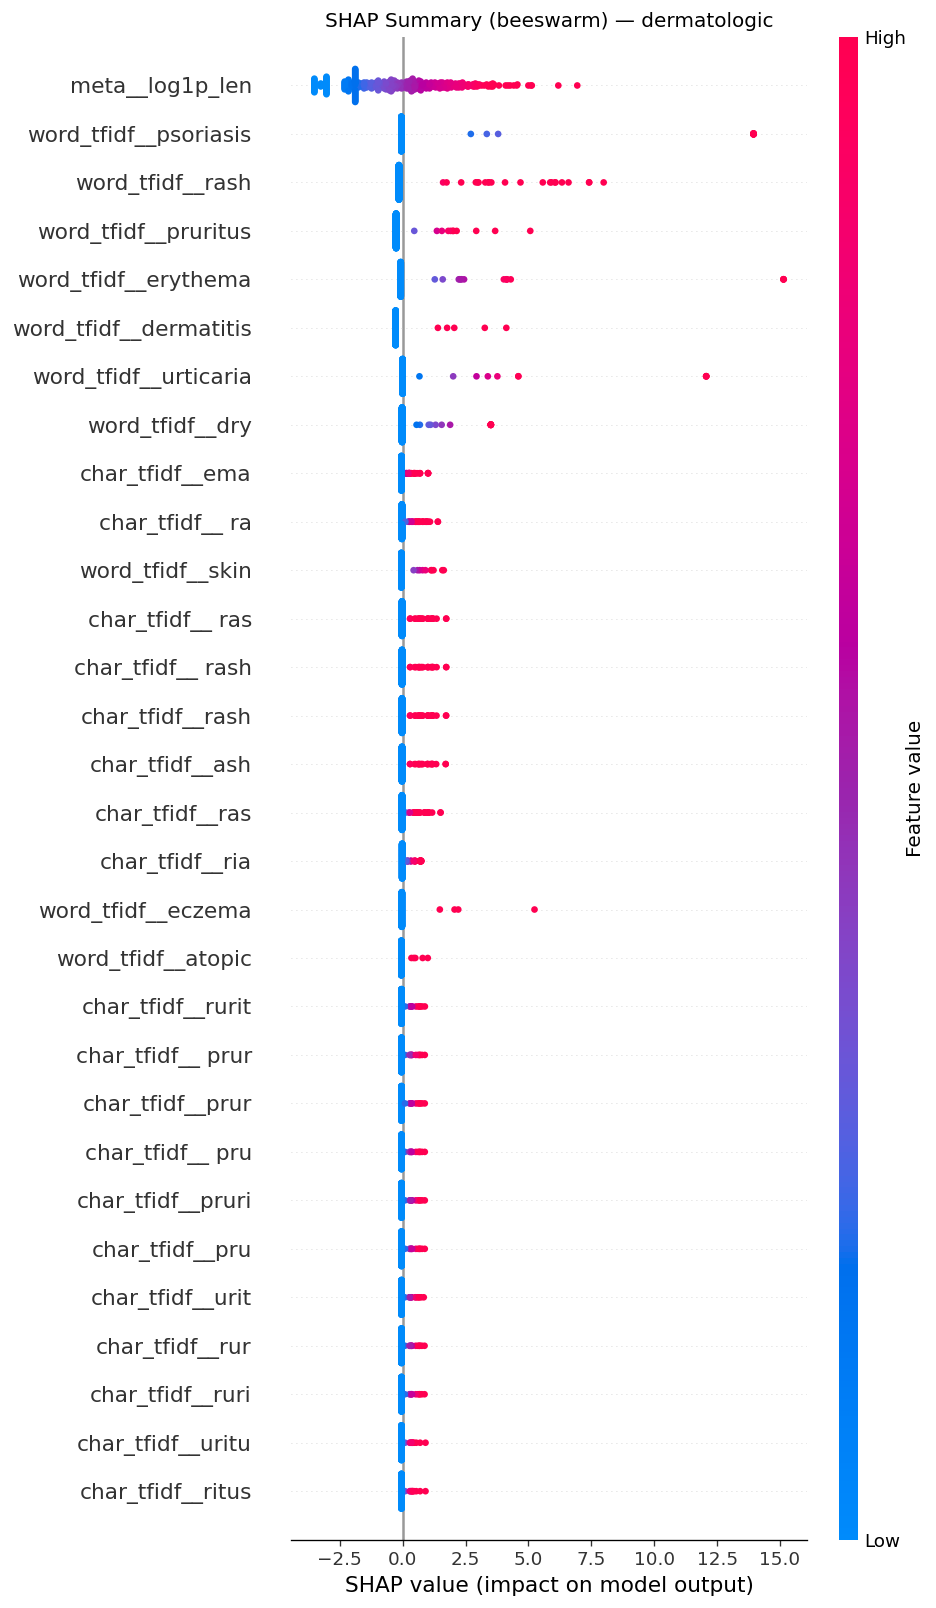

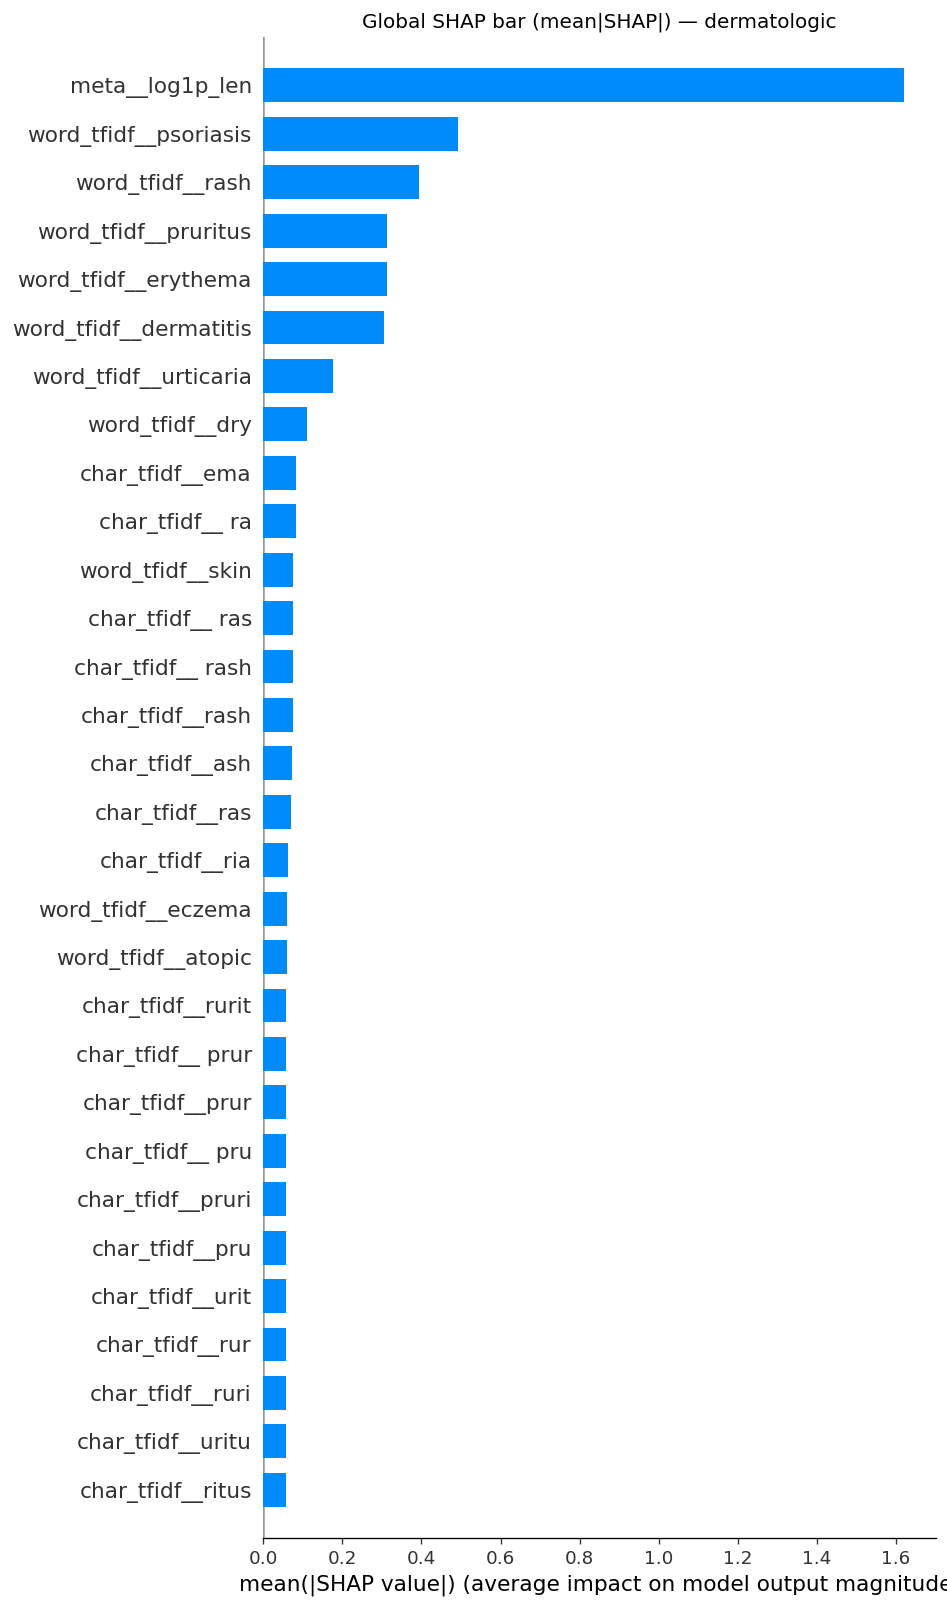

In [19]:
#CELL 7 — GLOBAL: shap_summary + global_shap_bar + summary_bar_topN
# TOP_N feature selection by mean(|SHAP|)
mean_abs = np.mean(np.abs(vals), axis=0)
topN = int(min(TOP_N, len(mean_abs)))
top_idx = np.argsort(mean_abs)[::-1][:topN]

vals_top = vals[:, top_idx]
X_top = X_explain[:, top_idx].toarray()     # faqat topN ni dense qilamiz
fn_top = feature_names_selected[top_idx]

# 1) beeswarm
shap.summary_plot(vals_top, X_top, feature_names=fn_top, show=False, max_display=topN)
save_and_show(VIS_DIR / "shap_summary.png", f"SHAP Summary (beeswarm) — {LABEL_TO_EXPLAIN}")

# 2) global bar (mean abs shap)
shap.summary_plot(vals_top, X_top, feature_names=fn_top, plot_type="bar", show=False, max_display=topN)
save_and_show(VIS_DIR / "global_shap_bar.png", f"Global SHAP bar (mean|SHAP|) — {LABEL_TO_EXPLAIN}")

# # 3) summary bar topN (same plot, different name)
# shap.summary_plot(vals_top, X_top, feature_names=fn_top, plot_type="bar", show=False, max_display=topN)
# save_and_show(VIS_DIR / "shap_summary_bar_topN.png", f"Top-{topN} mean(|SHAP|) — {LABEL_TO_EXPLAIN}")

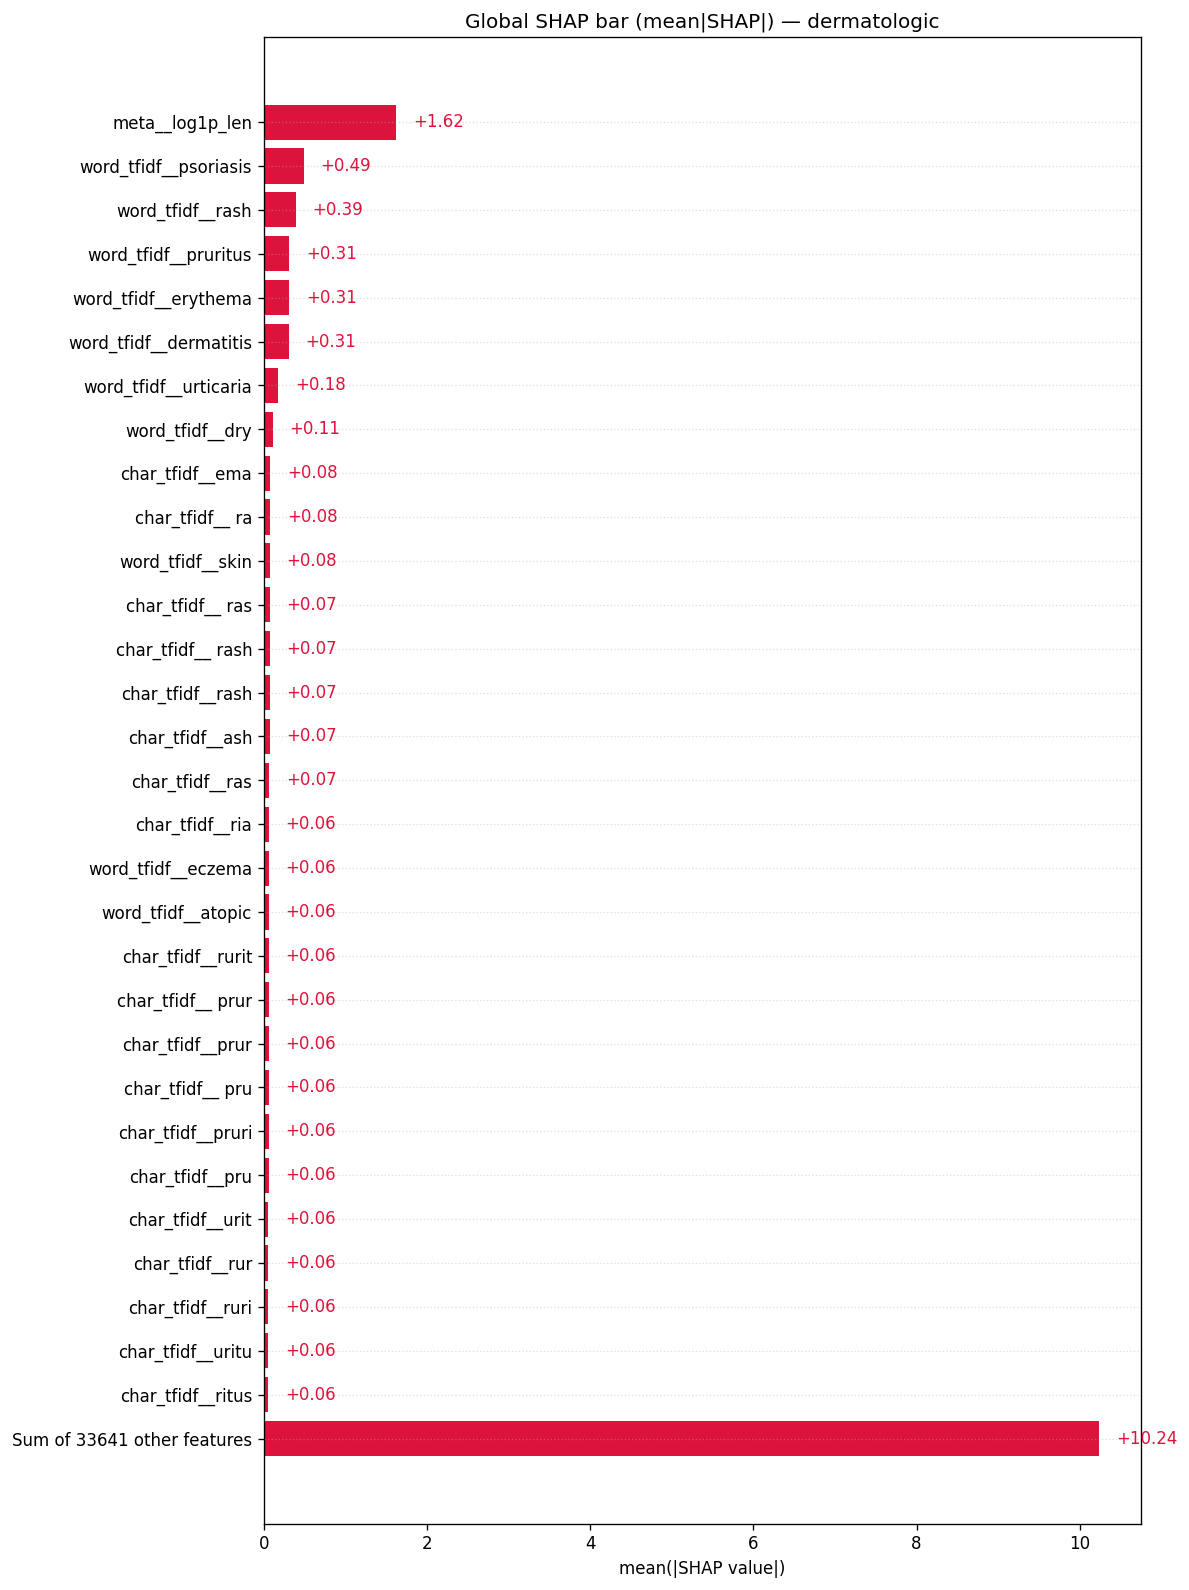

In [18]:
# topN feature’larni mean(|SHAP|) bo‘yicha oladi

# qolganlarini “Sum of N other features” qilib bitta qatorda jamlaydi

# har bar oxiriga +0.40 ko‘rinishida raqam yozadi

# global_shap_bar.png va shap_summary_bar_topN.png nomlari bilan VIS_DIR ga saqlaydi

# show() qiladi (run qilganda pastida ko‘rinadi)

# ✅ CELL 7 (rasmdagidek bar + raqam + “Sum of … other features”)
# =========================
# CELL 7 — GLOBAL: shap_summary + (custom) global_shap_bar w/ +numbers + "Sum of other features"
# =========================

# TOP_N feature selection by mean(|SHAP|)
mean_abs = np.mean(np.abs(vals), axis=0)
topN = int(min(TOP_N, len(mean_abs)))
top_idx = np.argsort(mean_abs)[::-1][:topN]

vals_top = vals[:, top_idx]
X_top = X_explain[:, top_idx].toarray()
fn_top = feature_names_selected[top_idx]

# # 1) beeswarm (shu normal)
# shap.summary_plot(vals_top, X_top, feature_names=fn_top, show=False, max_display=topN)
# save_and_show(VIS_DIR / "shap_summary.png", f"SHAP Summary (beeswarm) — {LABEL_TO_EXPLAIN}")

# ---------- custom bar plot (rasmdagidek) ----------
def global_bar_like_image(
    out_path,
    title,
    mean_abs_all,
    feature_names_all,
    top_idx,
    max_display=20,
    x_label="mean(|SHAP value|)",
    fmt_decimals=2,
):
    mean_abs_all = np.asarray(mean_abs_all, dtype=float)
    feature_names_all = np.asarray(feature_names_all, dtype=object)

    # top features
    top_vals = mean_abs_all[top_idx]
    top_names = feature_names_all[top_idx]

    # "Sum of N other features"
    n_features = len(mean_abs_all)
    n_other = n_features - len(top_idx)
    other_sum = float(mean_abs_all.sum() - top_vals.sum())

    # Plot order: biggest at top
    order = np.argsort(top_vals)[::-1]
    top_vals = top_vals[order]
    top_names = top_names[order]

    # add "other sum" as last row
    plot_vals = np.concatenate([top_vals, [other_sum]])
    plot_names = list(top_names) + [f"Sum of {n_other} other features"]

    k = len(plot_vals)
    plt.figure(figsize=(10, 0.35 * k + 2.5))

    y = np.arange(k)
    plt.barh(y, plot_vals, color="crimson")  # rasmga o‘xshash qizil

    plt.axvline(0, color="black", linewidth=1)
    plt.yticks(y, plot_names)
    plt.gca().invert_yaxis()  # yuqorida eng kattasi

    plt.xlabel(x_label)
    plt.grid(axis="y", linestyle=":", alpha=0.4)

    # annotate +numbers at bar end
    xmax = float(plot_vals.max()) if plot_vals.max() > 0 else 1.0
    pad = 0.02 * xmax

    for yi, v in zip(y, plot_vals):
        # "+0.40" ko‘rinish
        txt = f"{v:+.{fmt_decimals}f}"
        plt.text(v + pad, yi, txt, va="center", ha="left", color="crimson", fontsize=10)

    save_and_show(out_path, title)

# 2) global_shap_bar.png (rasmdagidek)
global_bar_like_image(
    out_path=VIS_DIR / "global_shap_bar.png",
    title=f"Global SHAP bar (mean|SHAP|) — {LABEL_TO_EXPLAIN}",
    mean_abs_all=mean_abs,
    feature_names_all=feature_names_selected,
    top_idx=top_idx,
    max_display=topN,
    x_label="mean(|SHAP value|)",
    fmt_decimals=2,
)

# # 3) shap_summary_bar_topN.png (xuddi shu, boshqa nom)
# global_bar_like_image(
#     out_path=VIS_DIR / "shap_summary_bar_topN.png",
#     title=f"Top-{topN} mean(|SHAP|) — {LABEL_TO_EXPLAIN}",
#     mean_abs_all=mean_abs,
#     feature_names_all=feature_names_selected,
#     top_idx=top_idx,
#     max_display=topN,
#     x_label="mean(|SHAP value|)",
#     fmt_decimals=2,
# )

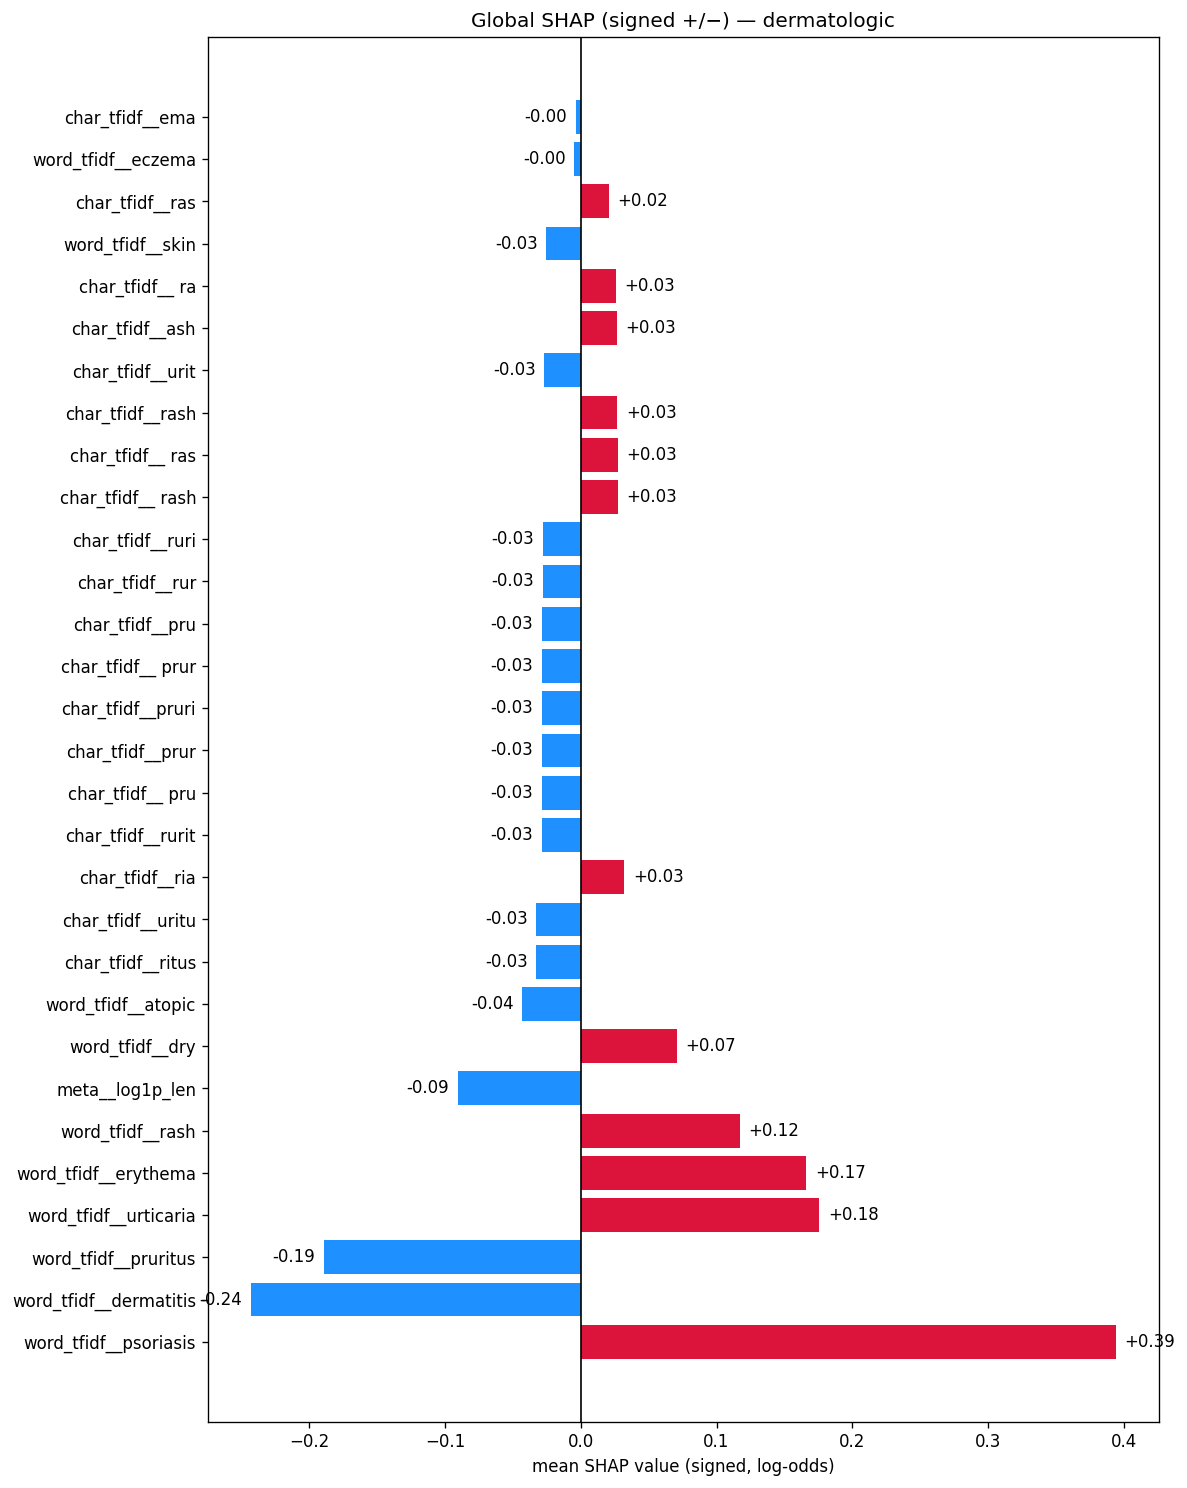

In [12]:
# GLOBAL: Signed bar (qizil=+, ko‘k=−, label yonida +/-)
# =========================
# GLOBAL SIGNED BAR (qizil/ko'k +/−)
# =========================
mean_abs = np.mean(np.abs(vals), axis=0)
topN = int(min(TOP_N, len(mean_abs)))
top_idx = np.argsort(mean_abs)[::-1][:topN]

vals_top = vals[:, top_idx]
fn_top = feature_names_selected[top_idx]

mean_signed_top = vals_top.mean(axis=0)              # signed mean SHAP
order = np.argsort(np.abs(mean_signed_top))[::-1]    # sort by |signed mean|
mean_signed_top = mean_signed_top[order]
fn_top_signed = fn_top[order]

colors = ["crimson" if v >= 0 else "dodgerblue" for v in mean_signed_top]

plt.figure(figsize=(10, 0.35 * topN + 2))
y = np.arange(topN)

plt.barh(y, mean_signed_top, color=colors)
plt.axvline(0, color="black", linewidth=1)
plt.yticks(y, fn_top_signed)
plt.xlabel("mean SHAP value (signed, log-odds)")

# +/− qiymatlarni yozib qo'yamiz
for yi, v in zip(y, mean_signed_top):
    txt = f"{v:+.2f}"
    if v >= 0:
        plt.text(v + 0.01 * (np.max(mean_signed_top) - np.min(mean_signed_top) + 1e-9), yi, txt, va="center", ha="left")
    else:
        plt.text(v - 0.01 * (np.max(mean_signed_top) - np.min(mean_signed_top) + 1e-9), yi, txt, va="center", ha="right")

save_and_show(VIS_DIR / "global_shap_bar_signed.png", f"Global SHAP (signed +/−) — {LABEL_TO_EXPLAIN}")

# “feature hissa qo‘shgan (+) / qo‘shmagan (−)” ko‘rinishga eng yaqin global variant.

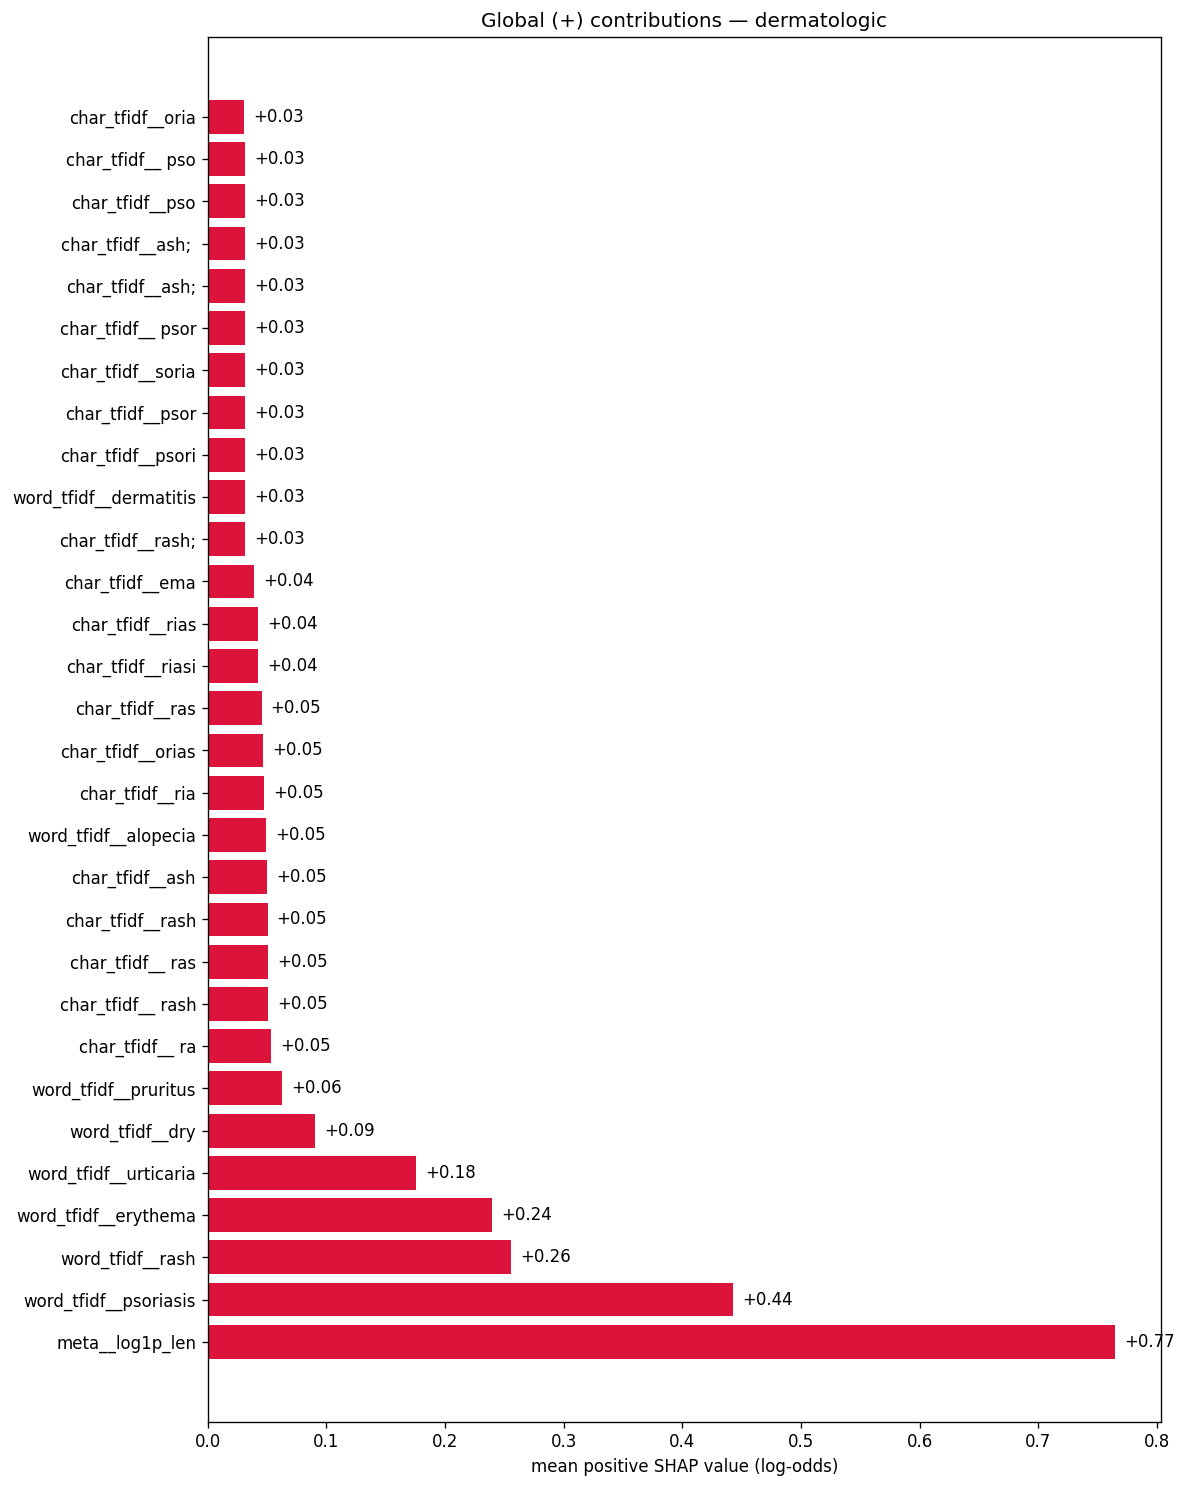

In [13]:
#2) GLOBAL: Positive-class bar (faqat + hissa, qizil)

# bu “global_shap_bar_positive_class” deganga mos: faqat positive contribution.

# =========================
# GLOBAL POSITIVE-ONLY BAR (faqat + hissa)
# =========================
pos_only = np.mean(np.clip(vals, 0, None), axis=0)   # faqat positive SHAP
top_idx_pos = np.argsort(pos_only)[::-1][:topN]

pos_vals = pos_only[top_idx_pos]
pos_feats = feature_names_selected[top_idx_pos]

plt.figure(figsize=(10, 0.35 * topN + 2))
y = np.arange(topN)

plt.barh(y, pos_vals, color="crimson")
plt.yticks(y, pos_feats)
plt.xlabel("mean positive SHAP value (log-odds)")

for yi, v in zip(y, pos_vals):
    plt.text(v + 0.01 * (np.max(pos_vals) + 1e-9), yi, f"{v:+.2f}", va="center", ha="left")

save_and_show(VIS_DIR / "global_shap_bar_positive_class.png", f"Global (+) contributions — {LABEL_TO_EXPLAIN}")

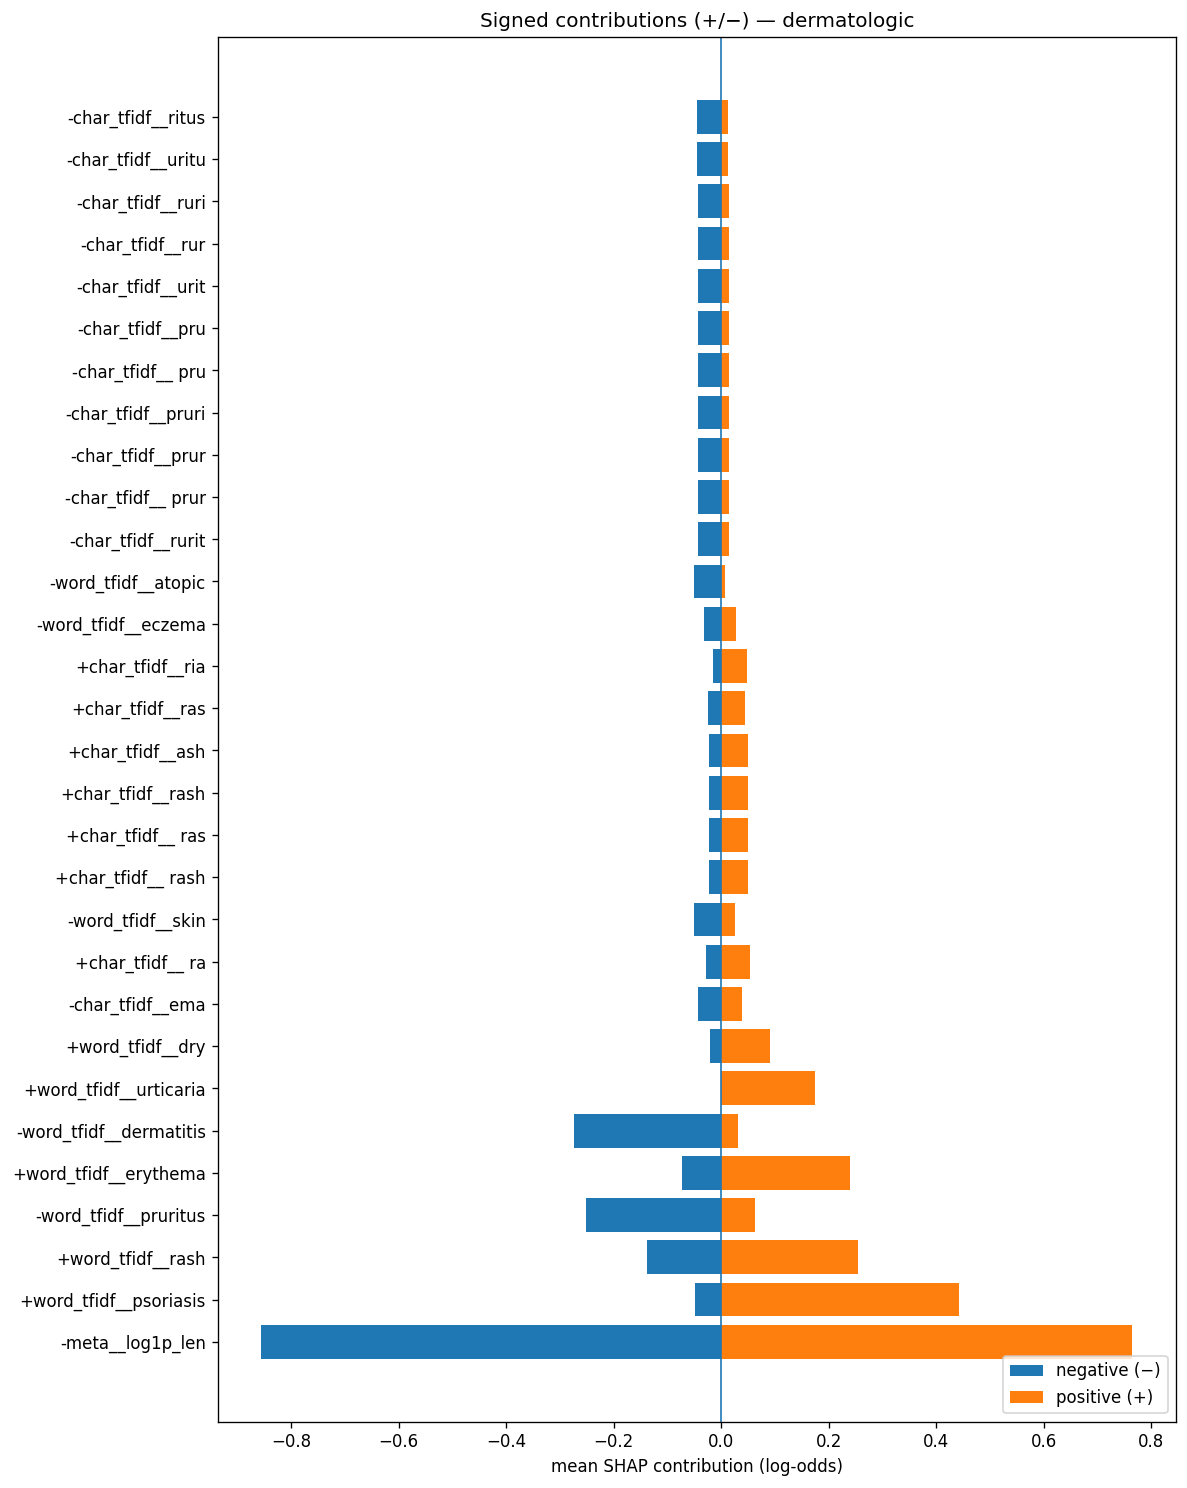

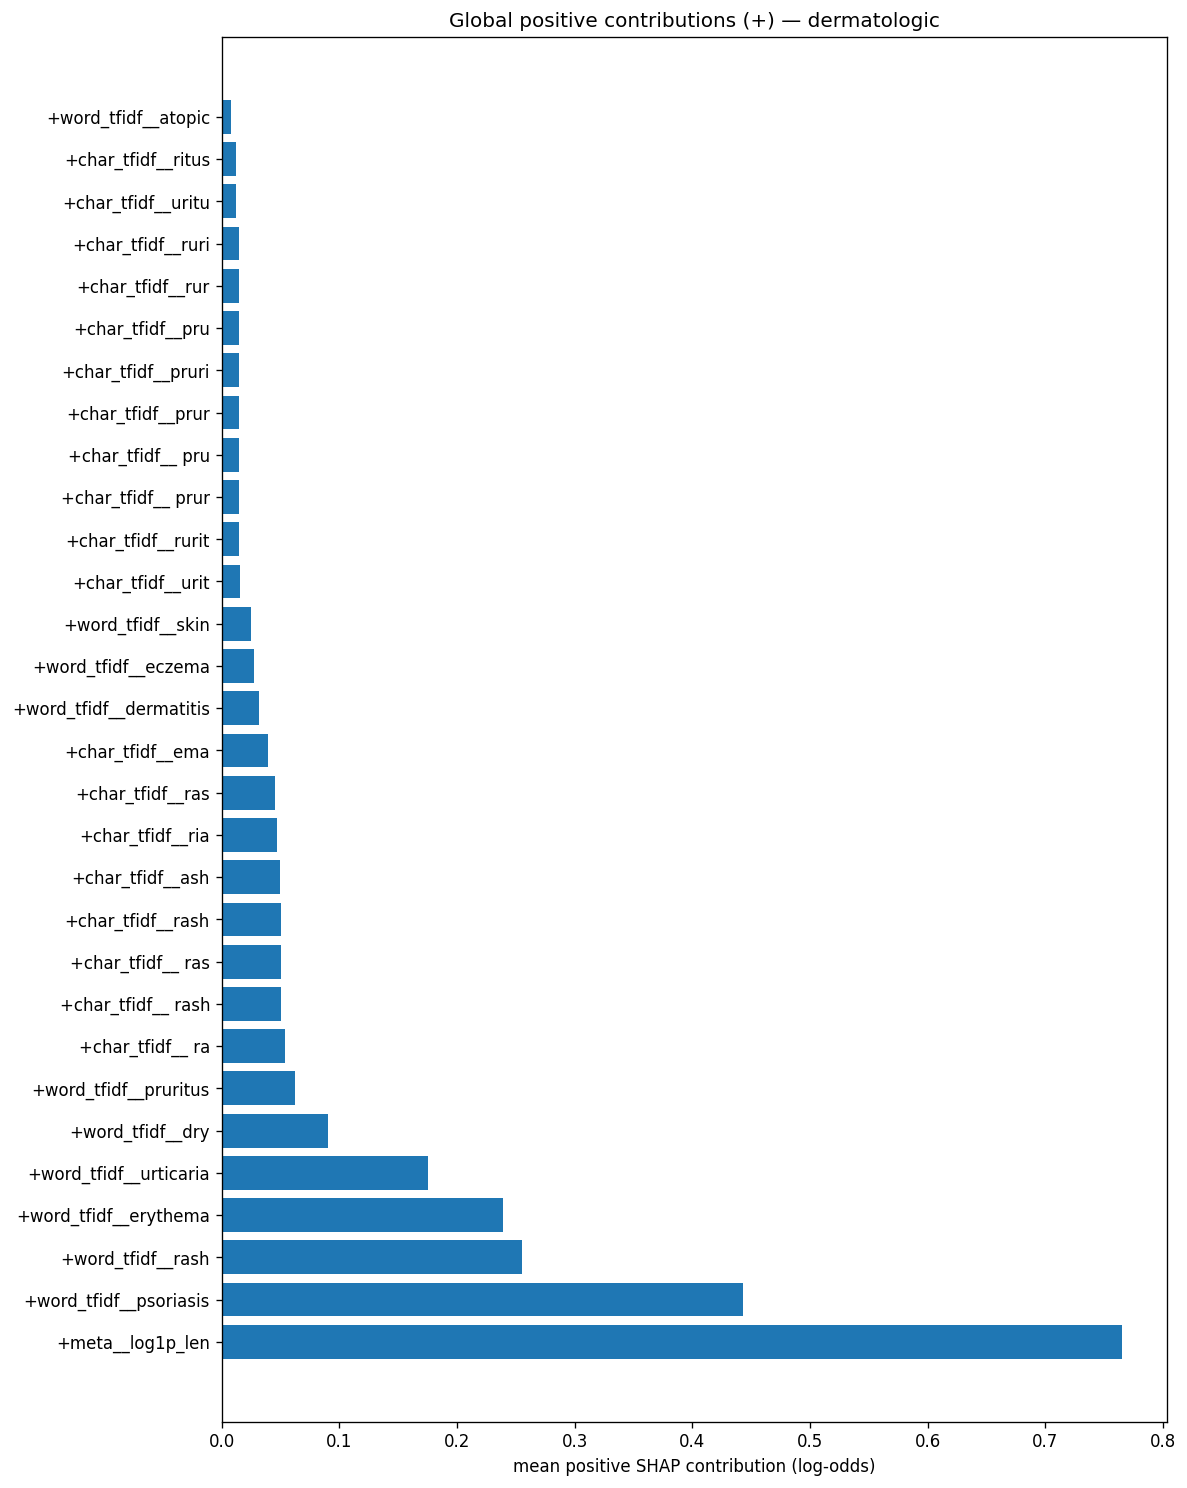

In [9]:
#CELL 8 — GLOBAL: “+=” signed contribution bar + positive-class bar (siz so‘ragan)

#Bu yerda feature nomlariga + yoki - qo‘shib ko‘rsatadi va barlar ham o‘ngga (+) / chapga (−) ketadi.

# Signed (mean SHAP) + Positive-only bar (mean positive SHAP)
mean_signed = np.mean(vals, axis=0)
pos_mean = np.mean(np.clip(vals, 0, None), axis=0)
neg_mean = np.mean(np.clip(vals, None, 0), axis=0)  # negative

# topN ni mean_abs bo‘yicha olamiz (yuqoridagi top_idx)
ms = mean_signed[top_idx]
pm = pos_mean[top_idx]
nm = neg_mean[top_idx]

# "+=" style: feature name prefix
fn_signed = [("+" if ms[i] >= 0 else "-") + fn_top[i] for i in range(len(fn_top))]

# --- (A) Signed bar: + va - bir grafikda ---
plt.figure(figsize=(10, 0.35 * topN + 2))
y = np.arange(topN)[::-1]

# barlar: negative chapga, positive o‘ngga
plt.barh(y, nm[::-1], label="negative (−)")
plt.barh(y, pm[::-1], label="positive (+)")

plt.yticks(y, fn_signed[::-1])
plt.axvline(0, linewidth=1)
plt.xlabel("mean SHAP contribution (log-odds)")
plt.legend(loc="lower right")

save_and_show(VIS_DIR / "shap_signed_bar_topN.png",
              f"Signed contributions (+/−) — {LABEL_TO_EXPLAIN}")

# --- (B) Positive class bar (faqat positive hissa) ---
order_pos = np.argsort(pm)[::-1]  # pos_mean katta -> yuqorida
pm_sorted = pm[order_pos]
fn_pos = [("+" + fn_top[i]) for i in order_pos]

plt.figure(figsize=(10, 0.35 * topN + 2))
y = np.arange(topN)[::-1]
plt.barh(y, pm_sorted[::-1])
plt.yticks(y, fn_pos[::-1])
plt.xlabel("mean positive SHAP contribution (log-odds)")

save_and_show(VIS_DIR / "global_shap_bar_positive_class.png",
              f"Global positive contributions (+) — {LABEL_TO_EXPLAIN}")

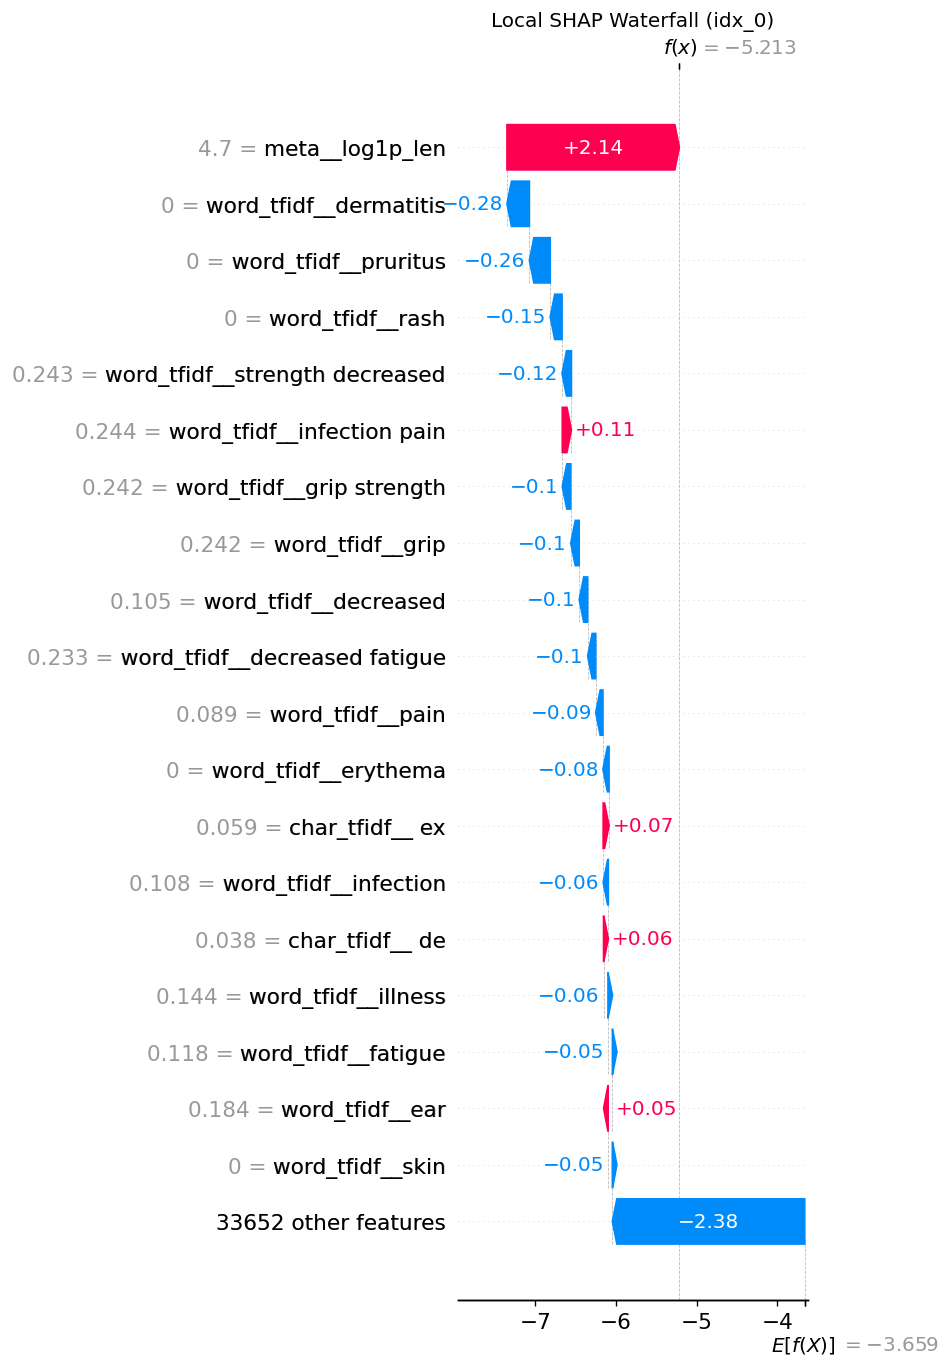

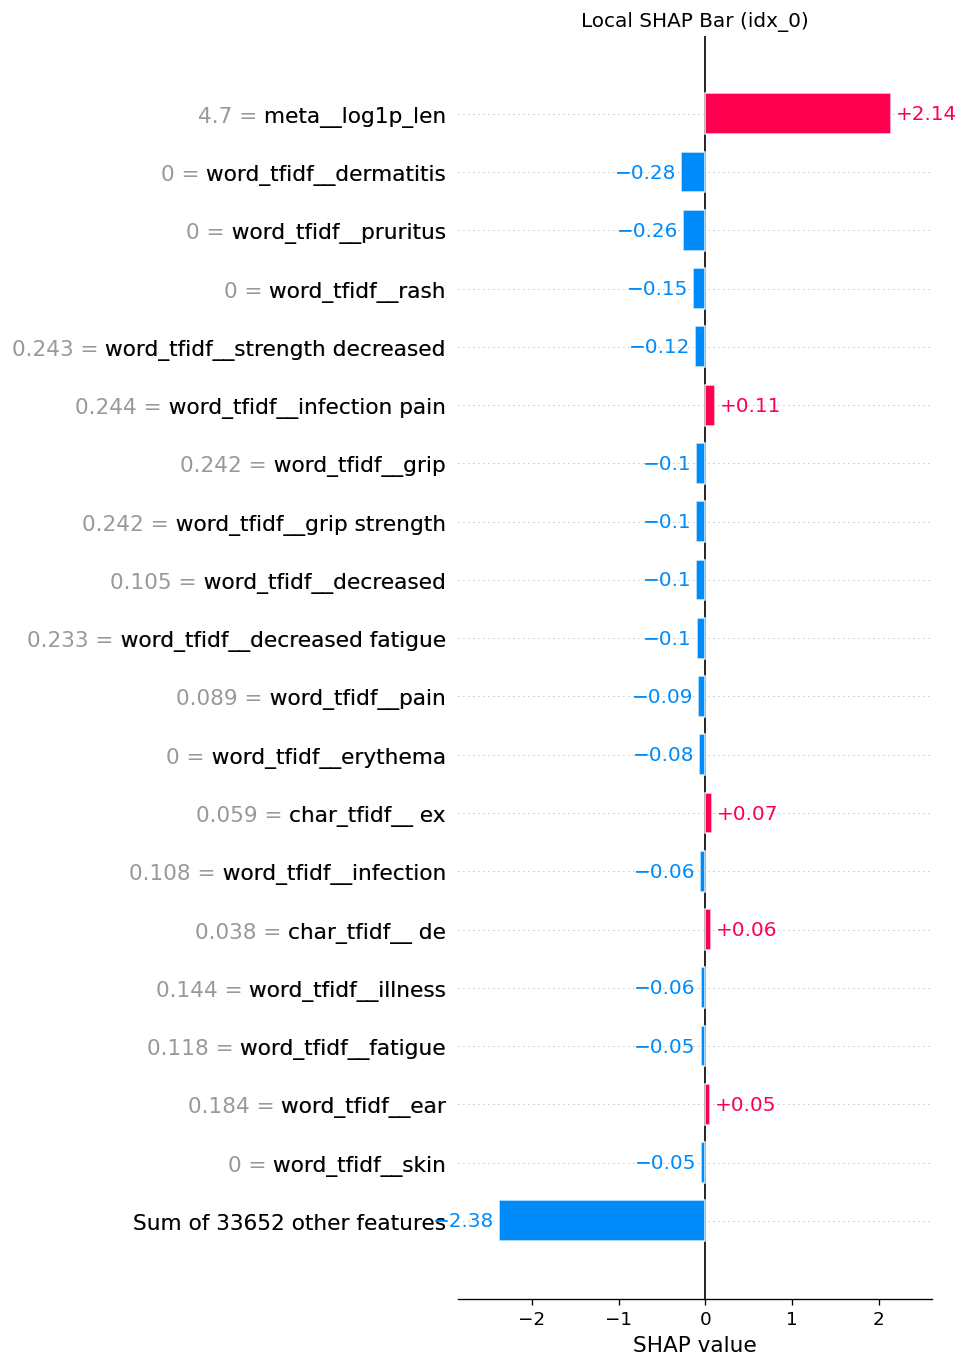

✅ Saved local force HTML: C:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\visuals\SHAP\local_shap_force_idx_0.html


In [10]:
# CELL 9 — LOCAL: waterfall + local bar + force HTML (idx_0)
# idx_0 — X_explain ichidagi 1-qatordan local explain
local0 = shap_exp[0]

# local waterfall
shap.plots.waterfall(local0, max_display=20, show=False)
save_and_show(VIS_DIR / "local_shap_waterfall_idx_0.png", "Local SHAP Waterfall (idx_0)")

# local bar
shap.plots.bar(local0, max_display=20, show=False)
save_and_show(VIS_DIR / "local_shap_bar_idx_0.png", "Local SHAP Bar (idx_0)")

# force html
force = shap.plots.force(local0.base_values, local0.values, local0.data,
                         feature_names=local0.feature_names, matplotlib=False)
shap.save_html(str(VIS_DIR / "local_shap_force_idx_0.html"), force)

print("✅ Saved local force HTML:", (VIS_DIR / "local_shap_force_idx_0.html").resolve())

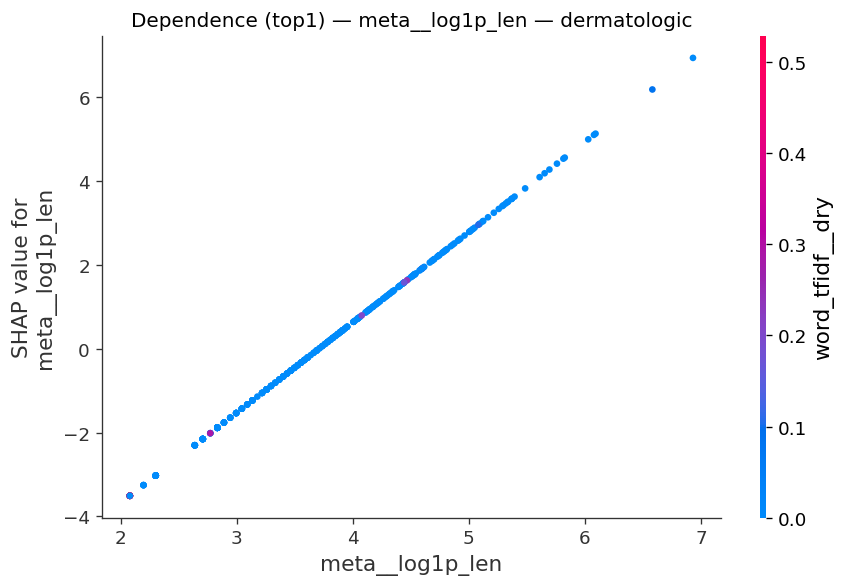

In [11]:
# CELL 10 — (Qo‘shimcha) dependence plot (top1)
# dependence plot for top1 feature (top_idx[0] top abs)
shap.dependence_plot(0, vals_top, X_top, feature_names=fn_top, show=False)
save_and_show(VIS_DIR / "shap_dependence_top1.png",
              f"Dependence (top1) — {fn_top[0]} — {LABEL_TO_EXPLAIN}")